### Objective
To determine if LSTM is useful in forcasting the direction(long/short) of an index.

### Procedure 

Load and sort data by date

Engineer features (returns, MA20, volatility)

Create target: Direction = (Close.shift(-1) > Close).astype(int)

Drop NaN rows caused by rolling indicators

Balance dataset by undersampling majority class

Split chronologically: 70% train / 15% val / 15% test

Scale features using StandardScaler

Convert data into sequences (60-day window)

Train LSTM classifier with class-weighted CrossEntropy + early stopping

Evaluate using accuracy, precision, recall, F1, confusion matrix

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/complete_nifty_50_historical_data_upto25-11.csv')

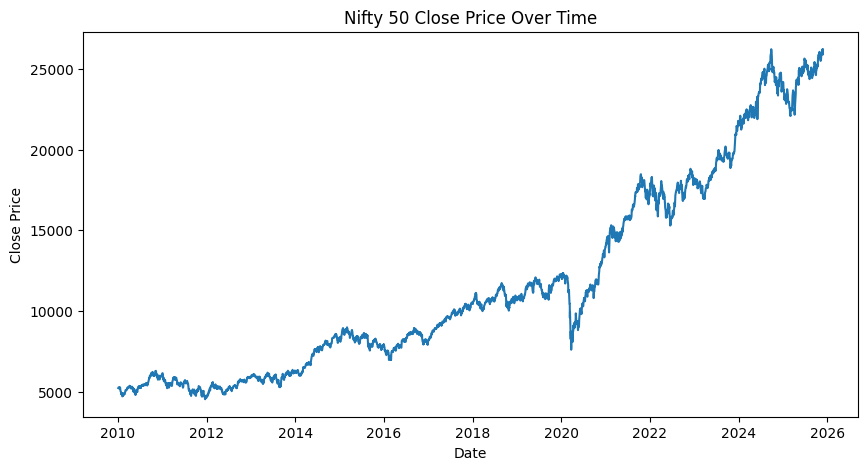

In [3]:
df["Date"] = pd.to_datetime(df["Date"])  # convert to datetime
df = df.sort_values("Date")
plt.figure(figsize=(10,5))
plt.plot(df['Date'],df['Close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('Nifty 50 Close Price Over Time')
plt.show()

### Creating a sequences dataset class

In [4]:

class SequenceDataset(Dataset):
    def __init__(self, features, targets, seq_len):
        self.features = features
        self.targets = targets
        self.seq_len = seq_len

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, index):
        X = self.features[index:index+self.seq_len]
        y = self.targets[index+self.seq_len]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [5]:
# feature_cols = [
#     "Close", "High", "Low", "Open", "Volume"
# ]

feature_cols = [
    "Close", "High", "Low", "Open", "Volume",
    "Return", "HighLow", "CloseOpen", "MA20"
]
df = df.drop(columns=["MA40", "LogReturn", "Volatility20"])

df["Direction"] = (df["Close"].shift(-1) > df["Close"]).astype(int)


# DROP NA ROWS
df = df.dropna(subset=feature_cols + ["Direction"]).reset_index(drop=True)

# Balance classes
count_up = df[df["Direction"] == 1].shape[0]
count_down = df[df["Direction"] == 0].shape[0]

min_class_count = min(count_up, count_down)

df_up = df[df["Direction"] == 1].sample(min_class_count, random_state=42)
df_down = df[df["Direction"] == 0].sample(min_class_count, random_state=42)

df = pd.concat([df_up, df_down]).sort_values("Date").reset_index(drop=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628 entries, 0 to 3627
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3628 non-null   datetime64[ns]
 1   Close      3628 non-null   float64       
 2   High       3628 non-null   float64       
 3   Low        3628 non-null   float64       
 4   Open       3628 non-null   float64       
 5   Volume     3628 non-null   int64         
 6   Return     3628 non-null   float64       
 7   HighLow    3628 non-null   float64       
 8   CloseOpen  3628 non-null   float64       
 9   MA20       3628 non-null   float64       
 10  Direction  3628 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 311.9 KB


In [7]:
df.head()

,Date,Close,High,Low,Open,Volume,Return,HighLow,CloseOpen,MA20,Direction
0,2010-02-01,4899.700195,4918.799805,4827.149902,4882.049805,163105434,0.003615,91.649903,17.650390,5143.397510,0
1,2010-02-02,4830.100098,4951.149902,4814.100098,4907.850098,167815142,-0.014205,137.049804,-77.750000,5123.292505,1
2,2010-02-03,4931.850098,4949.149902,4831.000000,4831.000000,222362365,0.021066,118.149902,100.850098,5105.990015,0
3,2010-02-04,4845.350098,4931.299805,4832.350098,4931.299805,22091127,-0.017539,98.949707,-85.949707,5084.167529,0
4,2010-02-08,4760.399902,4799.049805,4675.399902,4755.350098,175452494,0.008848,123.649903,5.049804,5032.727515,1


### Train / Validation / Test Split

In [8]:
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = df[:train_end]
val_df   = df[train_end:val_end]
test_df  = df[val_end:]

X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values
X_test  = test_df[feature_cols].values

y_train = train_df["Direction"].astype(int).values
y_val   = val_df["Direction"].astype(int).values
y_test  = test_df["Direction"].astype(int).values

In [9]:
# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


In [10]:
SEQ_LEN = 90

train_dataset = SequenceDataset(X_train, y_train, SEQ_LEN)
val_dataset   = SequenceDataset(X_val, y_val, SEQ_LEN)
test_dataset  = SequenceDataset(X_test, y_test, SEQ_LEN)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [13]:
# LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, num_features, hidden_size=16, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(num_features, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (h, _) = self.lstm(x)
        h = self.bn(h[-1])
        return self.fc(h)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(feature_cols)).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [29]:
def train_model(epochs=50, patience=10):
    best_val = float("inf")
    patience_counter = 0
    train_losses, val_losses = [], []
    flag  = 0

    for epoch in range(epochs):
        flag += 1
        model.train()
        total_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                val_loss += criterion(logits, y).item()

        val_losses.append(val_loss / len(val_loader))
        if flag ==1 or flag%10 == 0:
            print(f"Epoch {epoch+1}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}")
            if patience_counter >= patience:
                print(f"{patience_counter} epochs without improvement.")

        if val_losses[-1] < best_val:
            best_val = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            

    return train_losses, val_losses


In [30]:
train_losses, val_losses = train_model(epochs=100)

Epoch 1: Train 0.4364, Val 1.7886
Epoch 10: Train 0.4247, Val 1.6695
Epoch 20: Train 0.4021, Val 1.7338
15 epochs without improvement.
Epoch 30: Train 0.4086, Val 1.7628
Epoch 40: Train 0.4080, Val 1.7722
15 epochs without improvement.
Epoch 50: Train 0.4055, Val 1.6903
25 epochs without improvement.
Epoch 60: Train 0.3962, Val 1.6921
Epoch 70: Train 0.3908, Val 1.6802
10 epochs without improvement.
Epoch 80: Train 0.3853, Val 1.8496
20 epochs without improvement.
Epoch 90: Train 0.3771, Val 1.7355
30 epochs without improvement.
Epoch 100: Train 0.3787, Val 1.9203
40 epochs without improvement.


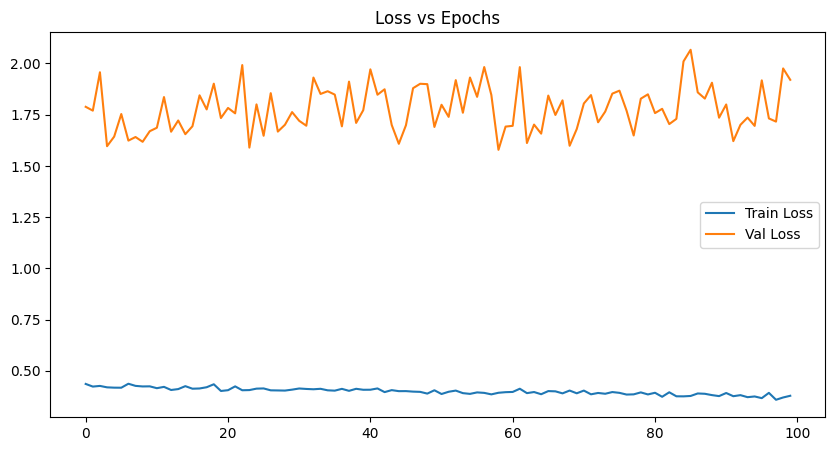

In [31]:
# Plot learning curve
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend() 
plt.title("Loss vs Epochs")
plt.show()

In [32]:
model.eval()
preds = []
actuals = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(torch.device("cpu"))
        logits = model(X)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)
        preds.extend(pred.cpu().numpy())
        actuals.extend(y.numpy())

preds = np.array(preds)
actuals = np.array(actuals)

acc = accuracy_score(actuals, preds)
prec = precision_score(actuals, preds)
recall = recall_score(actuals, preds)
f1 = f1_score(actuals, preds)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", confusion_matrix(actuals, preds))

Accuracy: 0.49230769230769234
Precision: 0.4857142857142857
Recall: 0.14847161572052403
F1-score: 0.22742474916387959
Confusion Matrix:
 [[190  36]
 [195  34]]


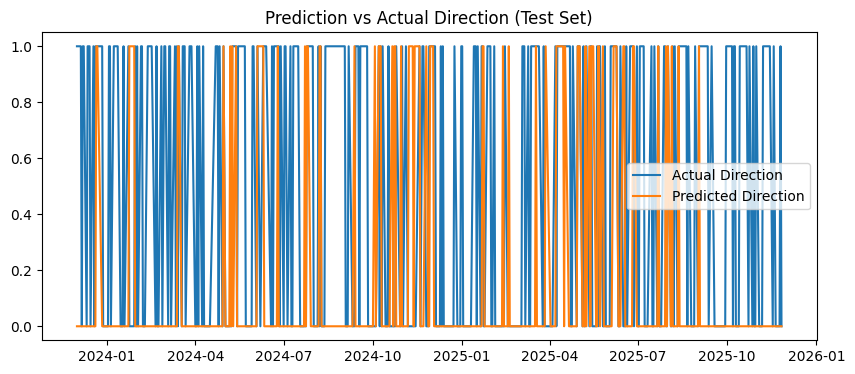

In [33]:
test_dates = test_df["Date"].iloc[SEQ_LEN:].reset_index(drop=True)
plt.figure(figsize=(10,4))
plt.plot(test_dates, actuals, label="Actual Direction")
plt.plot(test_dates, preds, label="Predicted Direction")
plt.title("Prediction vs Actual Direction (Test Set)")
plt.legend()
plt.show()

## RESULT 
### Result: ~49% accuracy and near-zero recall. Therefore no meaningful predictive power.
## Conclusion
LSTM performs poorly for predicting Nifty index direction because :
- daily index movements are highly noisy, 
- non-stationary, 
- weakly autocorrelated. <br>
Past data and technical indicators contain very little predictive signal for next-day up/down movement. With a small dataset (~3000 rows) and class imbalance, the model collapses to predicting the majority class, resulting in performance close to random. Stock indices are influenced mainly by news, macro events, and global sentiment — factors not captured in historical price patterns alone. Therefore, LSTM or any model is not effective for this task.

### THEREFORE LSTM SHOULD NOT BE USED FOR STOCK PRICE CLASSIFICATION.